## 安裝相關套件
* colab 或是 kaggle 執行以下block
* 其餘要根據 requirements.txt 決定哪些要下載

In [1]:
! pip install transformers
! pip install datasets
! pip install torcheval
! pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.9 MB/s eta 0:00:00a 0:00:01


## 引用套件並設置運行裝置

In [3]:
import transformers as T
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
from tqdm import tqdm
from ignite.metrics import Rouge
import matplotlib.pyplot as plt
import gc
import logging

# Adjust the logging level to suppress warnings
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("tokenizers").setLevel(logging.ERROR)

device = "cuda" if torch.cuda.is_available() else "cpu"

## 資料集分析
探討摘要原文的長度，可以發現大多集中在文本長度為95-115之間

In [3]:
df = load_dataset("hugcyp/LCSTS", split="train", cache_dir="./cache/").to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
df["text_length"] = df["text"].apply(lambda text: len(text))
df.head()

,summary,text,text_length
0,修改后的立法法全文公布,新华社受权于18日全文播发修改后的《中华人民共和国立法法》，修改后的立法法分为“总则”“法律...,97
1,深圳机场9死24伤续：司机全责赔偿或超千万,一辆小轿车，一名女司机，竟造成9死24伤。日前，深圳市交警局对事故进行通报：从目前证据看，事...,100
2,孟建柱：主动适应形势新变化提高政法机关服务大局的能力,1月18日，习近平总书记对政法工作作出重要指示：2014年，政法战线各项工作特别是改革工作取...,96
3,工信部约谈三大运营商严查通信违规,针对央视3·15晚会曝光的电信行业乱象，工信部在公告中表示，将严查央视3·15晚会曝光通信违...,104
4,食品一级召回限24小时内启动10工作日完成,国家食药监管总局近日发布《食品召回管理办法》，明确：食用后已经或可能导致严重健康损害甚至死亡...,101


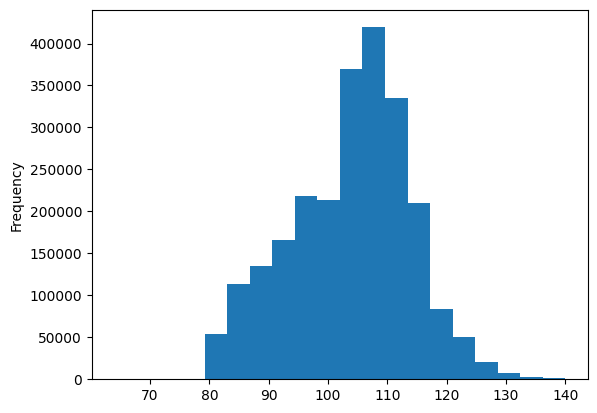

In [5]:
df["text_length"].plot(kind='hist', bins=20)
plt.show()

## T5 中文摘要
* 使用模型 flan-t5-base
* 由於資料集過於龐大，我採用隨機採樣的方式
    * 同時考慮到文本長度不平均的影響力，我簡單將文本長度以95, 115作為斷點切出三類，讓模型能夠看到不同長度的文本，而不會集中採樣在95-115之間

In [6]:
model = T.MT5ForConditionalGeneration.from_pretrained("google/mt5-base", cache_dir="./cache/").to(device)
tokenizer = T.MT5Tokenizer.from_pretrained("google/mt5-base", cache_dir="./cache/")

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [4]:
def group_length(length):
    # 依據長度切分三類
    if length <= 95:
        return 0
    elif 95 < length <= 115:
        return 1
    else:
        return 2

def get_tensor(sample, tokenizer):
    # 將模型的輸入和ground truth打包成Tensor
    model_inputs = tokenizer.batch_encode_plus([each["text"] for each in sample], max_length=256, padding=True, truncation=True, return_tensors="pt")
    model_outputs = tokenizer.batch_encode_plus([each["summary"] for each in sample], max_length=50, padding=True, truncation=True, return_tensors="pt")
    return model_inputs["input_ids"].to(device), model_outputs["input_ids"].to(device)

class SummaryDataset(Dataset):
    def __init__(self, split="train", ratio=1.0) -> None:
        super().__init__()
        assert split in ["train", "validation", "test"]
        
        # 下載資料
        df = load_dataset("hugcyp/LCSTS", split=split, cache_dir="./cache/").to_pandas()
        # 建立 text_length 長度欄位
        df["text_length_group"] = df["text"].apply(lambda text: group_length(len(text)))

        if (ratio < 1.0): # 使用隨機採樣
            # 每種長度區間採樣相同數量
            n_sample = int(len(df) * ratio / 3)
            self.data_df = df.groupby("text_length_group").sample(n=n_sample, random_state=0).reset_index(drop=True)
        else:
            # 不採樣
            self.data_df = df

    def __getitem__(self, index):
        return self.data_df.loc[index, :]

    def __len__(self):
        return len(self.data_df)


data_sample = SummaryDataset(split="train").data_df.loc[:3, :]
# 簡單看資料
print(f"Dataset example: \n{data_sample.iloc[0]} \n{data_sample.iloc[1]} \n{data_sample.iloc[2]}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset example: 
summary                                                    修改后的立法法全文公布
text                 新华社受权于18日全文播发修改后的《中华人民共和国立法法》，修改后的立法法分为“总则”“法律...
text_length_group                                                    1
Name: 0, dtype: object 
summary                                          深圳机场9死24伤续：司机全责赔偿或超千万
text                 一辆小轿车，一名女司机，竟造成9死24伤。日前，深圳市交警局对事故进行通报：从目前证据看，事...
text_length_group                                                    1
Name: 1, dtype: object 
summary                                     孟建柱：主动适应形势新变化提高政法机关服务大局的能力
text                 1月18日，习近平总书记对政法工作作出重要指示：2014年，政法战线各项工作特别是改革工作取...
text_length_group                                                    1
Name: 2, dtype: object


### 訓練參數設置
* 若使用colab可以看到表格形式，便於調參數

In [8]:
#@title  { display-mode: "form" }
learning_rate = 5e-5         #@param {type:"number"}
epochs = 3                   #@param {type:"integer"}
train_batch_size = 16        #@param {type:"integer"}
validation_batch_size = 16   #@param {type:"integer"}
train_ratio = 0.01           #@param {type:"number"}
step = 300                   #@param {type:"integer"}

In [24]:
summary_train = DataLoader(
    SummaryDataset(split="train", ratio=train_ratio),
    collate_fn=lambda sample: get_tensor(sample, tokenizer),
    batch_size=train_batch_size,
    shuffle=True
)
summary_validation = DataLoader(
    SummaryDataset(split="validation"),
    collate_fn=lambda sample: get_tensor(sample, tokenizer),
    batch_size=validation_batch_size,
    shuffle=False
)
rouge = Rouge(variants=["L", 2], multiref="best")

In [10]:
def evaluate(model, valid_loader):
    
    print("Start evaluation...")

    for inputs, targets in valid_loader:

        outputs = [each.replace("<pad>", "").replace("</s>", "") for each in tokenizer.batch_decode(model.generate(inputs, max_length=50))]
        targets = [each.replace("<pad>", "").replace("</s>", "") for each in tokenizer.batch_decode(targets)]
        
        for i in range(len(outputs)):
            # 中文不是用空格當分割 -> 而是用一個一個字 -> list 切開 string 
            candidate = list(outputs[i])
            ground_truth = [list(targets[i])]
            rouge.update(([candidate], [ground_truth]))
            
    return rouge.compute()


def get_eval_loss(model, valid_loader):
    
    for inputs, targets in valid_loader:
        # 紀錄當前的 loss 總和與資料數量
        total_loss, total_count = 0, 0
        with torch.no_grad():
            loss = model(input_ids=inputs, labels=targets).loss
            total_loss += loss.item()
            total_count += inputs.shape[0]
    return round(total_loss/total_count, 4)


In [11]:
def train(model, train_loader, valid_loader, model_name):
    
    # 紀錄訓練狀況
    train_losses = []
    eval_losses = []
    total_loss, total_count, curr_step, best_loss = 0, 0, 0, 10000
    
    optimizer = AdamW(model.parameters(), lr = learning_rate)
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer, 
        T_max=epochs * len(train_loader.dataset)
    )
    
    for ep in range(epochs):

        pbar = tqdm(train_loader)
        pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
        
        for inputs, targets in pbar:
            # 清空 gradient
            optimizer.zero_grad()
            # 更新參數
            loss = model(input_ids=inputs, labels=targets).loss
            loss.backward()
            optimizer.step()
            
            # 更新訓練狀況
            total_loss += loss.item()
            total_count += inputs.shape[0]
            curr_step += 1
            pbar.set_postfix(loss = round(total_loss/total_count, 4))
            
            scheduler.step()
            
            # 達到驗證step數
            if curr_step % step == 0:       
                train_losses.append(round(total_loss/total_count, 4))
                eval_loss = get_eval_loss(model, valid_loader)
                eval_losses.append(eval_loss)

                total_loss = 0
                total_count = 0
                
                if eval_loss < best_loss:
                    best_loss = eval_loss
                    # 驗證模型分數並儲存
                    torch.save(model, f'{model_name}_best.mod')
                    print(f"Rouge-2 score on step {curr_step // step}:", evaluate(model, summary_validation))
        
    return train_losses, eval_losses

In [12]:
train_losses, eval_losses = train(model, summary_train, summary_validation, "mt5")

Training epoch [1/3]:  20%|█▉        | 299/1501 [01:57<07:39,  2.62it/s, loss=0.399]

Start evaluation...


Training epoch [1/3]:  20%|█▉        | 300/1501 [06:30<27:28:47, 82.37s/it, loss=0.399]

Rouge-2 score on step 1: {'Rouge-L-P': 0.14836157743143055, 'Rouge-L-R': 0.19067246879325092, 'Rouge-L-F': 0.19067246879325092, 'Rouge-2-P': 0.08886748828842206, 'Rouge-2-R': 0.1169360715350157, 'Rouge-2-F': 0.1169360715350157}


Training epoch [1/3]:  40%|███▉      | 599/1501 [08:27<05:51,  2.57it/s, loss=0.138]   

Start evaluation...


Training epoch [1/3]:  40%|███▉      | 600/1501 [13:30<22:50:55, 91.29s/it, loss=0.138]

Rouge-2 score on step 2: {'Rouge-L-P': 0.21588239547743363, 'Rouge-L-R': 0.2163122360570656, 'Rouge-L-F': 0.2163122360570656, 'Rouge-2-P': 0.13952822695225414, 'Rouge-2-R': 0.13864623030251824, 'Rouge-2-F': 0.13864623030251824}


Training epoch [1/3]:  60%|█████▉    | 899/1501 [15:27<03:56,  2.54it/s, loss=0.134]   

Start evaluation...


Training epoch [1/3]:  60%|█████▉    | 900/1501 [20:23<14:53:18, 89.18s/it, loss=0.134]

Rouge-2 score on step 3: {'Rouge-L-P': 0.2584559006895168, 'Rouge-L-R': 0.2268498214433963, 'Rouge-L-F': 0.2268498214433963, 'Rouge-2-P': 0.1713150402742559, 'Rouge-2-R': 0.14803457899276404, 'Rouge-2-F': 0.14803457899276404}


Training epoch [1/3]:  80%|███████▉  | 1199/1501 [22:20<01:54,  2.64it/s, loss=0.13]   

Start evaluation...


Training epoch [1/3]:  80%|███████▉  | 1200/1501 [27:17<7:30:07, 89.73s/it, loss=0.13]

Rouge-2 score on step 4: {'Rouge-L-P': 0.27906447001563794, 'Rouge-L-R': 0.2341104815189693, 'Rouge-L-F': 0.2341104815189693, 'Rouge-2-P': 0.18692122714908055, 'Rouge-2-R': 0.15420027103157435, 'Rouge-2-F': 0.15420027103157435}


Training epoch [1/3]: 100%|█████████▉| 1499/1501 [29:15<00:00,  2.59it/s, loss=0.129]  

Start evaluation...


Training epoch [1/3]: 100%|██████████| 1501/1501 [34:17<00:00,  1.37s/it, loss=1.11] 


Rouge-2 score on step 5: {'Rouge-L-P': 0.29291104277384294, 'Rouge-L-R': 0.23788625475941122, 'Rouge-L-F': 0.23788625475941122, 'Rouge-2-P': 0.1977608033034818, 'Rouge-2-R': 0.15780668103452705, 'Rouge-2-F': 0.15780668103452705}


Training epoch [2/3]:  20%|█▉        | 298/1501 [01:56<07:47,  2.57it/s, loss=0.121]

Start evaluation...


Training epoch [2/3]:  20%|█▉        | 299/1501 [06:58<30:23:11, 91.01s/it, loss=0.121]

Rouge-2 score on step 6: {'Rouge-L-P': 0.30145972027877843, 'Rouge-L-R': 0.24010960412732926, 'Rouge-L-F': 0.24010960412732926, 'Rouge-2-P': 0.20437100306106795, 'Rouge-2-R': 0.1599462621402813, 'Rouge-2-F': 0.1599462621402813}


Training epoch [2/3]:  40%|███▉      | 598/1501 [08:55<05:50,  2.57it/s, loss=0.119]   

Start evaluation...


Training epoch [2/3]:  40%|███▉      | 599/1501 [14:14<24:01:53, 95.91s/it, loss=0.119]

Rouge-2 score on step 7: {'Rouge-L-P': 0.30656003617004574, 'Rouge-L-R': 0.24351866046895587, 'Rouge-L-F': 0.24351866046895587, 'Rouge-2-P': 0.20815577270632496, 'Rouge-2-R': 0.16256226762080436, 'Rouge-2-F': 0.16256226762080436}


Training epoch [2/3]:  60%|█████▉    | 898/1501 [16:12<03:54,  2.57it/s, loss=0.118]   

Start evaluation...


Training epoch [2/3]:  60%|█████▉    | 899/1501 [21:11<15:05:14, 90.22s/it, loss=0.118]

Rouge-2 score on step 8: {'Rouge-L-P': 0.3131531657447126, 'Rouge-L-R': 0.24556269132998612, 'Rouge-L-F': 0.24556269132998612, 'Rouge-2-P': 0.21321447112545203, 'Rouge-2-R': 0.16432744387404838, 'Rouge-2-F': 0.16432744387404838}


Training epoch [3/3]: 100%|██████████| 1501/1501 [14:32<00:00,  1.72it/s, loss=0.14]   


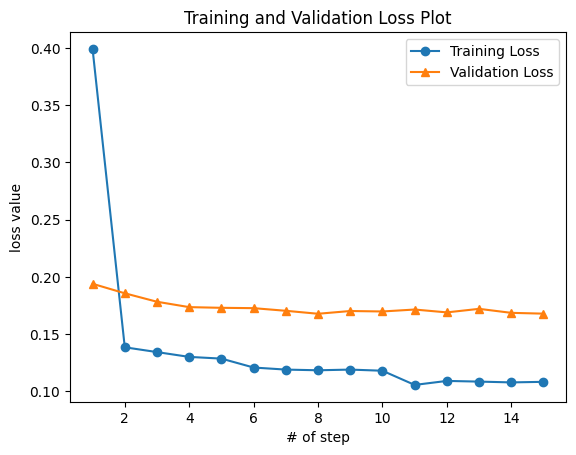

In [22]:
xticks = list( range(1, len(train_losses)+1, 1) )

plt.plot(xticks, train_losses, "-o", label="Training Loss")
plt.plot(xticks, eval_losses, "-^", label="Validation Loss")
plt.xlabel("# of step")
plt.ylabel('loss value')
plt.legend()
plt.title("Training and Validation Loss Plot")

plt.show()

### 測試最佳模型生成結果

In [28]:
model = torch.load("/kaggle/working/mt5_best.mod").to(device)
tokenizer = T.MT5Tokenizer.from_pretrained("google/mt5-base", cache_dir="./cache/")

for inputs, outputs in summary_validation:
    answers  = [each.replace("<pad>", "").replace("</s>", "") for each in tokenizer.batch_decode(outputs)]
    predicts = [each.replace("<pad>", "").replace("</s>", "") for each in tokenizer.batch_decode(model.generate(inputs, max_length=50))]
    
    for i, (ans, pred) in enumerate(zip(answers, predicts)):
        print(f"============================= {i+1} =============================")
        print(f"---> Ground Truth: {ans}")
        print(f"---> Prediction  : {pred}")
    
    break

============================= 1 =============================
---> Ground Truth: 林志颖公司疑涉虚假营销无厂房无研发
---> Prediction  :  爱碧丽假保健品售价高达4元
============================= 2 =============================
---> Ground Truth: 从韩亚航空事故看其应对路径
---> Prediction  :  三位一体呵护韩国形象
============================= 3 =============================
---> Ground Truth: 女子用板车拉九旬老母环游中国1年走2万4千里
---> Prediction  :  妈妈“一辈子在锅台边转”
============================= 4 =============================
---> Ground Truth: 银行集体发声:房贷政策没变
---> Prediction  :  多家银行:房价不会大涨大跌
============================= 5 =============================
---> Ground Truth: 四律师上书民航总局:起飞前应公布机长信息
---> Prediction  :  民航局:航班起飞前要向乘客公布机组人员信息
============================= 6 =============================
---> Ground Truth: 钱理群“告别教育”
---> Prediction  :  钱理群:教育无立足之地
============================= 7 =============================
---> Ground Truth: 中国游客大增多国放宽签证
---> Prediction  :  中泰免签政策
============================= 8 =============================
---> Ground Truth: 信披违规外加

### 清除不必要的 GPU 占用

In [11]:
del model
del tokenizer
del summary_validation
del summary_train

gc.collect()
torch.cuda.empty_cache()

## GPT-2 摘要

In [12]:
model = T.GPT2LMHeadModel.from_pretrained("gpt2", cache_dir="./cache/").to(device)
tokenizer = T.GPT2Tokenizer.from_pretrained("gpt2", padding_side='left', cache_dir="./cache/")

tokenizer.pad_token_id = tokenizer.eos_token_id # to avoid an error

In [6]:
#@title  { display-mode: "form" }

learning_rate = 3e-4         #@param {type:"number"}
epochs = 1                   #@param {type:"integer"}
train_batch_size = 8         #@param {type:"integer"}
validation_batch_size = 16    #@param {type:"integer"}
train_ratio = 0.01           #@param {type:"number"}
step = 600                   #@param {type:"integer"}

In [14]:
def get_gpt_tensor(sample, tokenizer, mask_non_summary=False):
    # 將模型的輸入和ground truth打包成Tensor
    model_inputs = tokenizer([each["text"] + " " + tokenizer.eos_token + " " + each["summary"] + " " + tokenizer.eos_token for each in sample], max_length=512, padding=True, truncation=True, return_tensors="pt")
    inputs = model_inputs["input_ids"]
    outputs = inputs.clone()
    
    # 避免 padding 的地方算到loss
    outputs[outputs == tokenizer.pad_token_id] = -100
    # 終止要學習
    outputs[:, -1] = tokenizer.pad_token_id
        
    return inputs.to(device), outputs.to(device)


summary_train = DataLoader(
    SummaryDataset(split="train", ratio=train_ratio),
    collate_fn=lambda sample: get_gpt_tensor(sample, tokenizer),
    batch_size=train_batch_size,
    shuffle=True
)
summary_validation = DataLoader(
    SummaryDataset(split="validation"),
    collate_fn=lambda sample: get_gpt_tensor(sample, tokenizer),
    batch_size=validation_batch_size,
    shuffle=False
)
rouge = Rouge(variants=["L", 2], multiref="best")

In [15]:
def evaluate(model, valid_loader):
    
    
    for inputs, targets in tqdm(valid_loader, leave=True):

        indices = (inputs==tokenizer.pad_token_id).nonzero()
        prompts = []
        answers = []

        for n_batch in range(len(inputs)):
            pos_pad = indices[ indices[:, 0] == n_batch ]
            if len(pos_pad) > 2:
                first, second, third = pos_pad[-3, 1]+1, pos_pad[-2, 1], pos_pad[-1, 1]
            else:
                first, second, third = 0, pos_pad[-2, 1], pos_pad[-1, 1]

            prompts.append(tokenizer.decode(inputs[n_batch, first: second+1]))
            answers.append(tokenizer.decode( inputs[n_batch, second: third] ).replace(tokenizer.eos_token, ""))

        encoding = tokenizer(prompts, padding=True, return_tensors='pt').to(device)
        predicts = model.generate(**encoding, max_length=512, pad_token_id=tokenizer.pad_token_id, do_sample=False)
        predicts = tokenizer.batch_decode(predicts, skip_special_tokens=True)

        for i, (pred, ans) in enumerate(zip(predicts, answers)): 
            # 中文不是用空格當分割 -> 而是用一個一個字 -> list 切開 string 
            candidate = list(pred[len(prompts[i])-len(tokenizer.eos_token):].strip())
            ground_truth = [list(ans)]
            rouge.update(([candidate], [ground_truth]))
            
    return rouge.compute()


def get_eval_loss(model, valid_loader):
    
    for inputs, targets in valid_loader:
        # 紀錄當前的 loss 總和與資料數量
        total_loss, total_count = 0, 0
        with torch.no_grad():
            loss = model(input_ids=inputs, labels=targets).loss
            total_loss += loss.item()
            total_count += inputs.shape[0]
    return round(total_loss/total_count, 4)

In [16]:
def train(model, train_loader, valid_loader, model_name):
    
    # 紀錄訓練狀況
    train_losses = []
    eval_losses = []
    total_loss, total_count, curr_step, best_loss = 0, 0, 0, 10000
    
    optimizer = AdamW(model.parameters(), lr = learning_rate)
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer, 
        T_max=epochs * len(train_loader.dataset)
    )
    
    for ep in range(epochs):

        pbar = tqdm(train_loader)
        pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
        
        for inputs, targets in pbar:
            # 清空 gradient
            optimizer.zero_grad()
            # 更新參數
            loss = model(input_ids=inputs, labels=targets).loss
            loss.backward()
            optimizer.step()
            
            # 更新訓練狀況
            total_loss += loss.item()
            total_count += inputs.shape[0]
            curr_step += 1
            pbar.set_postfix(loss = round(total_loss/total_count, 4))
            scheduler.step()
            
            # 達到驗證step數
            if curr_step % step == 0:       
                train_losses.append(round(total_loss/total_count, 4))
                eval_loss = get_eval_loss(model, valid_loader)
                eval_losses.append(eval_loss)

                total_loss = 0
                total_count = 0
                
                if eval_loss < best_loss:
                    best_loss = eval_loss
                    # 驗證模型分數並儲存
                    torch.save(model, f'{model_name}_best.mod')
                    print(f"Rouge-2 score on step {curr_step // step}:", evaluate(model, summary_validation))
        
        
    return train_losses, eval_losses

In [17]:
train_losses, eval_losses = train(model, summary_train, summary_validation, "gpt2")

Training epoch [1/1]:  20%|█▉        | 600/3001 [33:53<362:08:30, 542.99s/it, loss=0.316]

Rouge-2 score on step 1: {'Rouge-L-P': 0.14285480600436676, 'Rouge-L-R': 0.15387723655858848, 'Rouge-L-F': 0.15387723655858848, 'Rouge-2-P': 0.08484817230278403, 'Rouge-2-R': 0.09029125564805873, 'Rouge-2-F': 0.09029125564805873}


Training epoch [1/1]:  40%|███▉      | 1200/3001 [1:01:01<210:46:52, 421.33s/it, loss=0.278]

Rouge-2 score on step 2: {'Rouge-L-P': 0.1662496225784489, 'Rouge-L-R': 0.1615772333194876, 'Rouge-L-F': 0.1615772333194876, 'Rouge-2-P': 0.10107476656003828, 'Rouge-2-R': 0.09669633551777045, 'Rouge-2-F': 0.09669633551777045}


Training epoch [1/1]:  60%|█████▉    | 1800/3001 [1:26:00<127:36:09, 382.49s/it, loss=0.265]

Rouge-2 score on step 3: {'Rouge-L-P': 0.1756769812229241, 'Rouge-L-R': 0.16809265156573203, 'Rouge-L-F': 0.16809265156573203, 'Rouge-2-P': 0.10739649933457811, 'Rouge-2-R': 0.10123786387279134, 'Rouge-2-F': 0.10123786387279134}


Training epoch [1/1]:  80%|███████▉  | 2400/3001 [1:49:54<60:37:01, 363.10s/it, loss=0.257]

Rouge-2 score on step 4: {'Rouge-L-P': 0.1794828353227284, 'Rouge-L-R': 0.17578768376888385, 'Rouge-L-F': 0.17578768376888385, 'Rouge-2-P': 0.11033329470516717, 'Rouge-2-R': 0.10670526641476023, 'Rouge-2-F': 0.10670526641476023}


Training epoch [1/1]: 100%|██████████| 3001/3001 [2:09:50<00:00,  2.60s/it, loss=0.634] 

Rouge-2 score on step 5: {'Rouge-L-P': 0.1871819887761524, 'Rouge-L-R': 0.17855594539753228, 'Rouge-L-F': 0.17855594539753228, 'Rouge-2-P': 0.1158867805471963, 'Rouge-2-R': 0.10901401834757156, 'Rouge-2-F': 0.10901401834757156}


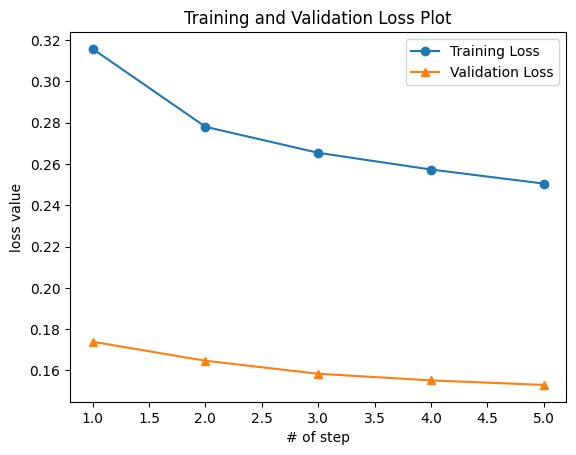

In [18]:
xticks = list( range(1, len(train_losses)+1, 1) )

plt.plot(xticks, train_losses, "-o", label="Training Loss")
plt.plot(xticks, eval_losses, "-^", label="Validation Loss")
plt.xlabel("# of step")
plt.ylabel('loss value')
plt.legend()
plt.title("Training and Validation Loss Plot")

plt.show()

### 測試最佳模型生成結果

In [19]:
model = torch.load("gpt2_best.mod").to(device)

for inputs, targets in summary_validation:

    indices = (inputs==tokenizer.pad_token_id).nonzero()
    prompts = []
    answers = []
    
    for n_batch in range(len(inputs)):
        pos_pad = indices[ indices[:, 0] == n_batch ]
        if len(pos_pad) > 2:
            first, second, third = pos_pad[-3, 1]+1, pos_pad[-2, 1], pos_pad[-1, 1]
        else:
            first, second, third = 0, pos_pad[-2, 1], pos_pad[-1, 1]
            
        prompts.append(tokenizer.decode(inputs[n_batch, first: second+1]))
        answers.append(tokenizer.decode( inputs[n_batch, second: third] ).replace(tokenizer.eos_token, ""))
    
    encoding = tokenizer(prompts, padding=True, return_tensors='pt').to(device)
    predicts = model.generate(**encoding, max_length=512, pad_token_id=tokenizer.pad_token_id, do_sample=False)
    predicts = tokenizer.batch_decode(predicts, skip_special_tokens=True)
    
    for i, (pred, ans) in enumerate(zip(predicts, answers)): 
        print(f"============================= {i+1} =============================")
        print(f"---> Prediction  : {pred[len(prompts[i])-len(tokenizer.eos_token):].strip()}")
        print(f"---> Ground Truth: {ans}")
    
    break

============================= 1 =============================
---> Prediction  : 丽没有自己生产加工厂
---> Ground Truth:  林志颖公司疑涉虚假营销无厂房无研发 
============================= 2 =============================
---> Prediction  : 韩方应对路径可以概括为
---> Ground Truth:  从韩亚航空事故看其应对路径 
============================= 3 =============================
---> Prediction  : 女妈妈环游中国妈妈环游被拉着
---> Ground Truth:  女子用板车拉九旬老母环游中国1年走2万4千里 
============================= 4 =============================
---> Prediction  : 包括工农：房价不具备大涨大跌
---> Ground Truth:  银行集体发声：房贷政策没变 
============================= 5 =============================
---> Prediction  : 十大飞行时间反映：沪上业内人士被安排执飞行员
---> Ground Truth:  四律师上书民航总局：起飞前应公布机长信息 
============================= 6 =============================
---> Prediction  : 钱理群：他以鲁迅自励
---> Ground Truth:  钱理群“告别教育” 
============================= 7 =============================
---> Prediction  : 游客可获得韩国多次签证：中国持通行证旅游公民全面开放
---> Ground Truth:  中国游客大增多国放宽签证 
============================= 8 ===========================